#  Homework 2
## Regularization, Logistic Regression


**Harvard University**<br/>
**Summer 2018**<br/>
**Instructor**: Pavlos Protopapas

---

### INSTRUCTIONS

- Submisson instructions:
  - Submit your Jupyter notebook to the teaching staff in an email.
  - The email should have the following subject:  gec-summer-2018 HW 1 "Your Name"
    - e.g. gec-summer2018 HW2 David Sondak
    
    **Homeworks with the wrong subject line will recieve a 0.**
  - The due date is Friday, June 22nd at 2:00 PM EDT.  Please note the time-zone!
    ** No late days!**

- Restart the kernel and run the whole notebook again before you submit. 
---

##### Import Libraries

In [61]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
%matplotlib inline

In [62]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# Part 1 [23 pts]: Regularization
## Problem Description:  Forecasting Bike Sharing Usage
Part 1 of this homework (HW2) continues Part 2 of HW1.  You will continue to build regression models for the Capital Bikeshare program in Washington D.C.  Part 2 of HW1 contains a detailed description of the dataset in case you need a reminder.

**Important:** The present problem (Part 1 of HW2) assumes that you have already pre-processed the dataset.  If you did not save the processed data from subparts $2.1$ and $2.2$ in HW1, then you must redo the pre-processing.  Specifically>
* You must convert categorical attributes into multiple binary attributes using one-hot encoding.
* Scale each continuous predictor to have zero mean and a standard deviation of  $1$.
See subpart $2.2$ in HW1 for even more details.

##### Goals of this Part
You will fit a multilinear regression model using using lasso and ridge regression and compare their performance.

In [63]:
dfbike_train = pd.read_csv("Bikeshare_train.csv")
dfbike_test = pd.read_csv("Bikeshare_test.csv")
dfbike_train = dfbike_train.rename(columns={"count":"TotalCount"})
dfbike_test = dfbike_test.rename(columns={"count":"TotalCount"})

In [64]:
#season
season = pd.get_dummies(dfbike_train['season']) 
season = season.rename(columns={1.0:"Spring",2.0:"Summer",3.0:"Fall",4.0:"Winter"}) 
season.pop('Winter')
#month
month = pd.get_dummies(dfbike_train.month)
month = month.rename(columns={1.0:"Jan",2.0:"Feb",3.0:"Mar",4.0:"Apr",5.0:"May",6.0:"Jun",7.0:"Jul",8.0:"Aug",9.0:"Sep",10.0:"Oct",11.0:"Nov",12.0:"Dec"})
month.pop('Dec')
#holiday
holiday = pd.get_dummies(dfbike_train.holiday)
holiday = holiday.rename(columns={0.0:"is_not_holiday",1.0:"is_holiday"})
holiday.pop('is_not_holiday')
#day_of_week
week = pd.get_dummies(dfbike_train.day_of_week)
week = week.rename(columns={0.0:"Sun",1.0:"Mon",2.0:"Tue",3.0:"Wed",4.0:"Thu",5.0:"Fri",6.0:"Sat"})
week.pop('Sun')
#workingday
workingday = pd.get_dummies(dfbike_train.workingday) 
workingday = workingday.rename(columns={0.0:"is_not_workingday",1.0:"is_workingday"})
workingday.pop('is_not_workingday')
#weather
weather = pd.get_dummies(dfbike_train.weather)
weather = weather.rename(columns={1.0:"weather_1.0",2.0:"weather_2.0",3.0:"weather_3.0"})

In [65]:
temp_mean = dfbike_train.temp.mean()
atemp_mean = dfbike_train.atemp.mean()
humidity_mean = dfbike_train.humidity.mean()
windspeed_mean = dfbike_train.windspeed.mean()
temp_std = dfbike_train.temp.std()
atemp_std = dfbike_train.atemp.std()
humidity_std = dfbike_train.humidity.std()
windspeed_std = dfbike_train.windspeed.std()

In [66]:
#Normal
def normalize_function(the_col):
    mean = the_col.mean()
    std = the_col.std()
    the_col = the_col.apply(lambda x: (x - mean)/std)
    return the_col

In [67]:
dfbike_train.temp = normalize_function(dfbike_train.temp)
dfbike_train.atemp = normalize_function(dfbike_train.atemp)
dfbike_train.humidity = normalize_function(dfbike_train.humidity)
dfbike_train.windspeed = normalize_function(dfbike_train.windspeed)

In [68]:
dfbike_train = pd.concat([season,month,holiday,week,workingday,weather,dfbike_train.temp,dfbike_train.atemp,dfbike_train.humidity,dfbike_train.windspeed,dfbike_train.TotalCount],axis=1)

In [69]:
#dfbike_train

In [70]:
#Normal
def test_normalize_function(mean, std, the_col):
    the_col = the_col.apply(lambda x: (x - mean)/std)
    return the_col

In [71]:
#season
season_test = pd.get_dummies(dfbike_test['season']) 
season_test = season_test.rename(columns={1.0:"Spring",2.0:"Summer",3.0:"Fall",4.0:"Winter"})
season_test.pop('Winter')
#month
month_test = pd.get_dummies(dfbike_test.month)
month_test = month_test.rename(columns={1.0:"Jan",2.0:"Feb",3.0:"Mar",4.0:"Apr",5.0:"May",6.0:"Jun",7.0:"Jul",8.0:"Aug",9.0:"Sep"})
month_test = month_test.rename(columns={10.0:"Oct",11.0:"Nov",12.0:"Dec"})
month_test.pop('Dec')
#holiday
holiday_test = pd.get_dummies(dfbike_test.holiday)
holiday_test = holiday_test.rename(columns={0.0:"is_not_holiday",1.0:"is_holiday"})
holiday_test.pop('is_not_holiday')
#day_of_week
week_test = pd.get_dummies(dfbike_test.day_of_week)
week_test = week_test.rename(columns={0.0:"Sun",1.0:"Mon",2.0:"Tue",3.0:"Wed",4.0:"Thu",5.0:"Fri",6.0:"Sat"})
week_test.pop('Sun')
#workingday
workingday_test = pd.get_dummies(dfbike_test.workingday) 
workingday_test = workingday_test.rename(columns={0.0:"is_not_workingday",1.0:"is_workingday"})
workingday_test.pop('is_not_workingday')
#weather
weather_test = pd.get_dummies(dfbike_test.weather)
weather_test = weather_test.rename(columns={1.0:"weather_1.0",2.0:"weather_2.0",3.0:"weather_3.0"})

In [72]:
#Normal
def test_normalize_function(mean, std, the_col):
    the_col = the_col.apply(lambda x: (x - mean)/std)
    return the_col

In [73]:
dfbike_test.temp = test_normalize_function(temp_mean, temp_std, dfbike_test.temp)
dfbike_test.atemp = test_normalize_function(atemp_mean, atemp_std, dfbike_test.atemp)
dfbike_test.humidity = test_normalize_function(humidity_mean, humidity_std,dfbike_test.humidity)
dfbike_test.windspeed = test_normalize_function(windspeed_mean, windspeed_std, dfbike_test.windspeed)

In [74]:
dfbike_test = pd.concat([season_test,month_test,holiday_test,week_test,workingday_test,weather_test,dfbike_test.temp,dfbike_test.atemp,dfbike_test.humidity,dfbike_test.windspeed,dfbike_test.TotalCount],axis=1)

## Part 1.1 [23 pts]:  Ridge and Lasso Regression

### Part 1.1.1 [5 pts]:  Fit Linear, Ridge, and Lasso Regression Models
Use the following regression techniques to fit linear models to the training set:
- Ridge regression
- Lasso regression

Choose the regularization parameter $\lambda$ from the set $\{0.001, 0.005,..., 50, 100\}$ using cross-validation.

#### Hints
- You may use `sklearn`'s `LinearRegression`, `RidgeCV` and `LassoCV` classes to implement Linear, Ridge, and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values.
- You may use the `plt.errorbar` function to plot confidence bars for the average $R^2$ scores.

#### Deliverables
Your code should be contained in a Jupyter notebook cell.  An appropriate level of comments is necessary.  Your code should run and output the required outputs described below.

#### Required Outputs
- Print the train and test $R^2$ scores for each model

In [75]:
dftrain = dfbike_train
dftest = dfbike_test
# Extract training and test data
xtrain = dftrain.drop(columns='TotalCount').values
ytrain = dftrain['TotalCount'].values
xtest = dftest.drop(columns='TotalCount').values
ytest = dftest['TotalCount'].values

# Regularization paramete set
lambd = np.concatenate(([0.001, 0.005, 0.05, 10, 80], [np.linspace(8.5, 15, num=66)], [20, 50, 100]), axis=None)

# Linear Regression
Linear = LinearRegression()
result = Linear.fit(xtrain, ytrain)
score0 = result.score(xtrain, ytrain)
score1 = result.score(xtest, ytest)
# Lasso
LASSO = LassoCV(alphas=lambd,cv=5, max_iter=2000) # choose 5-folds CV
Lresult = LASSO.fit(xtrain, ytrain)
Lscore0 = Lresult.score(xtrain, ytrain)
Lscore1 = Lresult.score(xtest, ytest)
# Ridge
ridge = RidgeCV(alphas=lambd,cv=5)
Rresult = ridge.fit(xtrain, ytrain)
Rscore0 = Rresult.score(xtrain, ytrain)
Rscore1 = Rresult.score(xtest, ytest)

print('the training R^2 score for Linear Regression is: {}'.format(score0))
print('the test R^2 score for Linear Regression is: {}'.format(score1))
print('the training R^2 score for Lasso Regression is: {}, and the corresponding lambda is: {}'.format(Lscore0, Lresult.alpha_))
print('the test R^2 score for Lasso Regression is: {}'.format(Lscore1))
print('the training R^2 score for Ridge Regression is: {}, and the corresponding lambda is: {}'.format(Rscore0, Rresult.alpha_))
print('the test R^2 score for Ridge Regression is: {}'.format(Rscore1))

the training R^2 score for Linear Regression is: 0.5761281783129482
the test R^2 score for Linear Regression is: 0.24934211146527574
the training R^2 score for Lasso Regression is: 0.551481499784902, and the corresponding lambda is: 20.0
the test R^2 score for Lasso Regression is: 0.2710576153540979
the training R^2 score for Ridge Regression is: 0.5609168048297487, and the corresponding lambda is: 13.2
the test R^2 score for Ridge Regression is: 0.267333345758211


/Users/mac/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [76]:
print('the coefficients of Linear Regression: {}'.format(result.coef_))
print('the coefficients of Lasso Regression: {}'.format(Lresult.coef_))
print('the coefficients of Ridge Regression: {}'.format(Rresult.coef_))

the coefficients of Linear Regression: [-1226.18654265  -327.35750316  -193.30496781   118.83581872
   207.77591139   358.01671712   452.18490513    53.02331873
  -673.42707979 -1161.15118754  -657.63967119   523.98038482
   605.08672238   231.51746394  -284.35627461  -123.75147639
  -195.28593262   170.51134687    61.25602987   111.06689939
   465.14500996   308.15314174   532.84828921   516.28170519
 -1049.1299944    925.73384986   312.43407189  -548.49294906
  -255.12258899]
the coefficients of Lasso Regression: [-1012.71632154     0.          -133.60365301   -35.66510115
    -0.             0.             0.             0.
  -174.04253807  -470.37139831    -0.           652.87602943
   537.05580716     0.            -0.          -106.19683984
    -0.             3.8361371      0.            12.28112222
   105.8336792    108.90852763    26.21542821     0.
  -797.18241414   488.70626903   498.80833763  -512.21079837
  -233.69057222]
the coefficients of Ridge Regression: [-718.2271929

In [77]:
absr=abs(result.coef_)
absL=abs(Lresult.coef_)
absR=abs(Rresult.coef_)

In [78]:
print('The clossest to 0 coef of Linear, Lasso & Ridge:{}, {}, {}'.format(np.amin(absr),np.amin(absL),np.amin(absR)))

The clossest to 0 coef of Linear, Lasso & Ridge:53.02331873119945, 0.0, 26.696163885252595


In [79]:
print('The Max coef of Linear, Lasso & Ridge:{}, {}, {}'.format(np.amax(result.coef_),np.amax(Lresult.coef_),np.amax(Rresult.coef_)))
print('The Min coef of Linear, Lasso & Ridge:{}, {}, {}'.format(np.amin(result.coef_),np.amin(Lresult.coef_),np.amin(Rresult.coef_)))

The Max coef of Linear, Lasso & Ridge:925.7338498566336, 652.8760294316189, 596.5195277344287
The Min coef of Linear, Lasso & Ridge:-1226.1865426521529, -1012.7163215372285, -718.2271929898343


In [80]:
Columns = dftrain.drop(columns='TotalCount').columns.values
index = np.argwhere(abs(Lresult.coef_)<1e-10)
q3 = Columns[index]
print('For LASSO, the predictors with 0 coefficient are:{}'.format(q3.reshape(1,-1)))

For LASSO, the predictors with 0 coefficient are:[['Summer' 'Feb' 'Mar' 'Apr' 'May' 'Aug' 'Nov' 'is_holiday' 'Tue' 'Thu'
  'weather_2.0']]


In [81]:
from sklearn.model_selection import train_test_split

def sample(x, y, k):
    n = x.shape[0] # No. of training points
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    # Get predictors and reponses with the indices
    x_subset = x[subset_ind, :]
    y_subset = y[subset_ind]

    return (x_subset, y_subset)

K = [100, 150, 200, 250, 300, 350, 400]
score_lin_train = {}
score_lin_test = {}
score_lasso_train = {}
score_lasso_test = {}
score_ridge_train = {}
score_ridge_test = {}

for k in K:
    score_lin_train[k] = {}
    score_lin_test[k] = {}
    score_lasso_train[k] = {}
    score_lasso_test[k] = {}
    score_ridge_train[k] = {}
    score_ridge_test[k] = {}
    # Draw subsamples
    x, y = sample(xtrain, ytrain, k)
    # Repeat random split 10 times and store R^2 for both training and test set
    for i in range(10):
        xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)
        # For linear reg
        result_lin = LinearRegression().fit(xtrain, ytrain)
        score_lin_train[k][i] = result_lin.score(xtrain, ytrain)
        score_lin_test[k][i] = result_lin.score(xtest, ytest)
        # For LASSO
        result_LA = Lasso(alpha=50).fit(xtrain, ytrain)
        score_lasso_train[k][i] = result_LA.score(xtrain, ytrain)
        score_lasso_test[k][i] = result_LA.score(xtest, ytest)
        # For Ridge
        result_R = Ridge(alpha=50).fit(xtrain, ytrain)
        score_ridge_train[k][i] = result_R.score(xtrain, ytrain)
        score_ridge_test[k][i] = result_R.score(xtest, ytest)

In [82]:
mean_lin_train = {}
std_lin_train = {}
mean_lin_test = {}
std_lin_test = {}
mean_lasso_train = {}
std_lasso_train = {}
mean_lasso_test = {}
std_lasso_test = {}
mean_ridge_train = {}
std_ridge_train = {}
mean_ridge_test = {}
std_ridge_test = {}

for k in K:
    mean_lin_train[k] =np.mean(list(score_lin_train[k].values()))
    std_lin_train[k] = np.std(list(score_lin_train[k].values()))
    mean_lin_test[k] = np.mean(list(score_lin_test[k].values()))
    std_lin_test[k] = np.std(list(score_lin_test[k].values()))
    mean_lasso_train[k] = np.mean(list(score_lasso_train[k].values()))
    std_lasso_train[k] = np.std(list(score_lasso_train[k].values()))
    mean_lasso_test[k] = np.mean(list(score_lasso_test[k].values()))
    std_lasso_test[k] = np.std(list(score_lasso_test[k].values()))
    mean_ridge_train[k] = np.mean(list(score_ridge_train[k].values()))
    std_ridge_train[k] = np.std(list(score_ridge_train[k].values()))
    mean_ridge_test[k] = np.mean(list(score_ridge_test[k].values()))
    std_ridge_test[k] = np.std(list(score_ridge_test[k].values()))

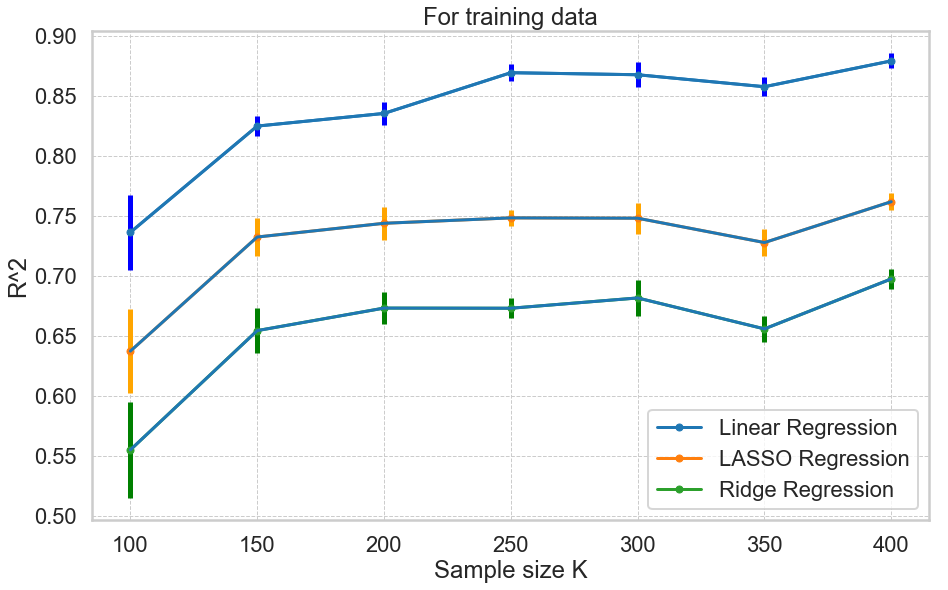

In [83]:
plt.rcParams["figure.figsize"] = (15,9)
plt.rcParams.update({'font.size': 15})

plt.plot(K, list(mean_lin_train.values()), 'o-', ms=7, label='Linear Regression')
plt.errorbar(K, list(mean_lin_train.values()), yerr=std_lin_train.values(), ecolor='b', elinewidth=5)
plt.plot(K, list(mean_lasso_train.values()), 'o-', ms=7, label='LASSO Regression')
plt.errorbar(K, list(mean_lasso_train.values()), yerr=std_lasso_train.values(), ecolor='orange', elinewidth=5)
plt.plot(K, list(mean_ridge_train.values()), 'o-', ms=7, label='Ridge Regression')
plt.errorbar(K, list(mean_ridge_train.values()), yerr=std_ridge_train.values(), ecolor='g', elinewidth=5)
plt.grid(linestyle='--', linewidth=1)
plt.legend()
plt.xlabel("Sample size K")
plt.ylabel("R^2")
plt.title("For training data")
plt.show()

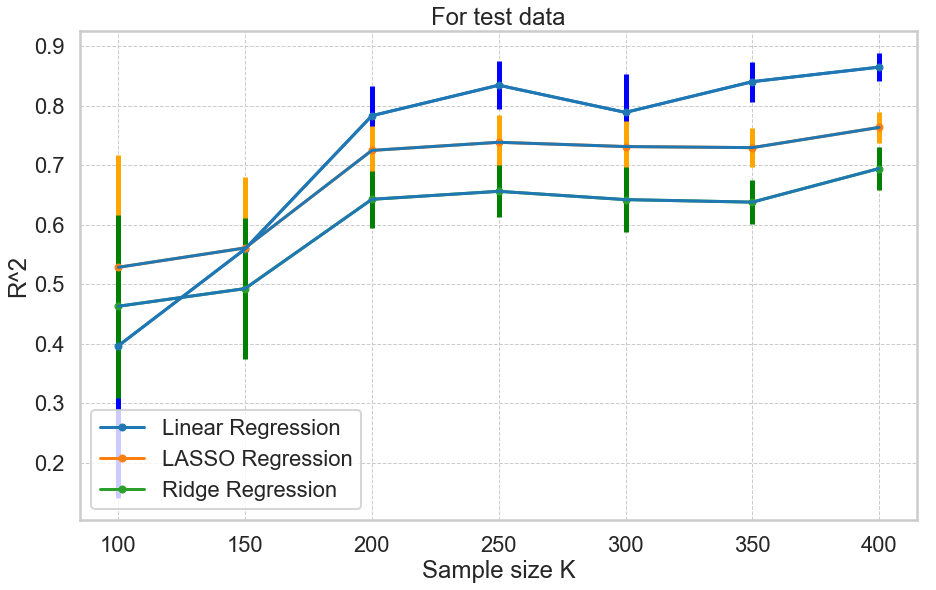

In [84]:
plt.plot(K, mean_lin_test.values(), 'o-', ms=7, label='Linear Regression')
plt.errorbar(K, mean_lin_test.values(), yerr=std_lin_test.values(), ecolor='b', elinewidth=5)
plt.plot(K, mean_lasso_test.values(), 'o-', ms=7, label='LASSO Regression')
plt.errorbar(K, mean_lasso_test.values(), yerr=std_lasso_test.values(), ecolor='orange', elinewidth=5)
plt.plot(K, mean_ridge_test.values(), 'o-', ms=7, label='Ridge Regression')
plt.errorbar(K, mean_ridge_test.values(), yerr=std_ridge_test.values(), ecolor='g', elinewidth=5)
plt.grid(linestyle='--', linewidth=1)
plt.legend()
plt.xlabel("Sample size K")
plt.ylabel("R^2")
plt.title("For test data")
plt.show()

# 1. Linear Regression Model

train_dict = {}
test_dict = {}
valid_dict={}
train_errors = np.zeros((248,4))
valid_errors = np.zeros((248,4))
fold = 0
for train, valid in kfold.split(range(n_smalltrain)):
    regression = LinearRegression()
    #f # split data into train/test groups, 4 times
    for d in degrees:
        kfold.split(range(n_smalltrain))
        train_dict = {}
        test_dict = {}
        valid_dict={}
        train_dict[d]=xtrain[train]
        valid_dict[d]=xtrain[valid]
        regression = LinearRegression()
        regression.fit(train_dict[d], ytrain[train]) # fit
        train_errors[d,fold] = mean_squared_error(regression.predict(train_dict[d]),ytrain[train]) # evaluate score function on held-out data
        valid_errors[d,fold]= mean_squared_error(regression.predict(valid_dict[d]),ytrain[valid]) # evaluate score function on held-out data
    fold += 1

mean_train_errors = train_errors.mean(axis=1)
mean_valid_errors = valid_errors.mean(axis=1)
std_train_errors = train_errors.std(axis=1)
std_valid_errors = valid_errors.std(axis=1)

mindeg = np.argmin(mean_valid_errors)
print(mindeg)

post_cv_train_dict = xtrain
test_dict = xtest
#fit on whole training set now.
regression = LinearRegression()
regression.fit(post_cv_train_dict[mindeg], ytrain) # fit
pred = regression.predict(test_dict[mindeg])

err = mean_squared_error(pred, ytest)
errtr = mean_squared_error(ytrain, est.predict(post_cv_train_dict[mindeg]))

# 2. RidgeCV Regression Model

# 3. LassoCV Regression Model

### 1.1.2 [4 pts]:  Discuss your results by answering the following questions:
1. [1 pt] How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without regularzation)?

  *Your answer here.*

2. [1 pt] Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.

  *Your answer here.*

3. [1 pt] List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods.

  *Your answer here.*

4. [1 pt] Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

  *Your answer here.*

### 1.1.3 [10 pts]:  Analyze the performance of the two regularization methods for different training sample sizes
It would be nice to assess the performance of the regularization methods to figure out which one works better.  To do this, you will execute the following steps:
- Generate random samples of sizes 100, 150, ..., 400 from the training set.
- Do a random split of the data at each sample size.  You will do this 10 times.
- Fit linear, Ridge and Lasso models on each training set.
- Calculate the mean $R^2$ score and it's standard deviation (SD) for each model.
- Compare the performance.

#### Hints
- You may use the following code to draw a random sample of a specified size from the training set:

```python
#--------  sample
# A function to select a random sample of size k from the training set
# Input: 
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data)
#      k (size of sample) 
# Return: 
#      chosen sample of predictors and responses

def sample(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k.astype(int))
    
    # Get predictors and reponses with the indices
    x_subset = x[subset_ind, :]
    y_subset = y[subset_ind]
    
    return (x_subset, y_subset)
```

#### Deliverables
Your code should be contained in a Jupyter notebook cell.  An appropriate level of comments is necessary.  Your code should run and output the required outputs described below.

#### Required Outputs
- Fit Linear, Ridge and Lasso regression models to each of the generated samples. 
  - In each case, compute the $R^2$ score for the model on the training sample on which it was fitted and on the test set.
- Repeat the above experiment for $10$ random trials
  - Compute the average train and test $R^2$ across the trials for each training sample size.
  - Compute the standard deviation (SD) in each case.
- Make a plot of the mean training $R^2$ scores for the Linear, Ridge and Lasso regression methods as a function of the training sample size.
- Show a confidence interval for the mean scores extending from **mean - SD** to **mean + SD**.
- Make a similar plot for the test $R^2$ scores.

### 1.1.4 [3 pts]:  Discuss your results by answering the following questions:
1. [1 pt] How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations.

  *Your answer here.*

2. [1 pt] How do the confidence intervals for the estimated $R^2$ change with training sample size?

  *Your answer here.*

3. [1 pt] Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

  *Your answer here.*


---

# Part 2 [20 pts]:  Logistic Regression

## Problem Description:  Cancer Classification from Gene Expressions

In this part of the assignment, you will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. 

The data set is provided in the file `dataset_hw2.csv`. 
* Rows in the file:  tumor tissue samples from a patient with one of the two forms of leukemia. 
* The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. 
* Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

##### Goals of this part
Use logistic regression to build a classification model for this data set.

## Part 2.1 [6 pts]: Data Exploration

### Part 2.1.1 [2 pts]:  Pre-processing
* Split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).
```python
np.random.seed(9001)
df = pd.read_csv('dataset_hw2.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]
```
* Take a peak at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

#### Deliverables
Your code should be contained in a Jupyter notebook cell. An appropriate level of comments is necessary. Your code should run.

#### Required Outputs
None for this section.

### Part 2.1.2 [2 pts]:  Heat Map
A convenient tool to visualize the gene expression data is a heat map. 
* Arrange the rows of the training set so that the *AML* rows are grouped together and the *ALL* rows are together. * * Generate a heat map of the data with expression values from the following genes:
  - `D49818_at`
  - `M23161_at`
  - `hum_alu_at`
  - `AFFX-PheX-5_at`
  - `M15990_at`

  **Hint:** Take a look at the `seaborn` `heatmap` method:  [`seaborn` heat map](https://seaborn.pydata.org/generated/seaborn.heatmap.html) and [seaborn-heatmap-using-pandas-dataframe](https://stackoverflow.com/questions/37790429/seaborn-heatmap-using-pandas-dataframe).

#### Deliverables
Your code should be contained in a Jupyter notebook cell. An appropriate level of comments is necessary. Your code should run and output the required outputs described below.

#### Required Outputs
1. A properly labeled heat map.
  * Properly labeled means $x$ and $y$ axes are labeled and a colorbar is included.

### Part 2.1.3 [2 pts]:  Discussion Questions

1. [1 pt] Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

  *Your answer here.*

2. [1 pt] By observing the heat map, comment on which of these genes are useful in discriminating between the two classes.

  *Your answer here.*

## Part 2.2 [14 pts]:  Linear Regression vs. Logistic Regression
In this part, you will analyze the differences between using linear regression and logistic regression for classification. For this part, you will work with a single gene predictor: `D29963_at`.

### 2.2.1 [2 pts]:  Linear Regression
* Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`.

#### Deliverables
Your code should be contained in a Jupyter notebook cell. An appropriate level of comments is necessary. Your code should run and output the required outputs described below.

#### Required Outputs
* Print the prediction from the linear regression model, $\widehat{y}_{\textrm{test}}$

### 2.2.2: [2 pts]  Convert to Classification Model
The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into the `ALL` type (class 1), and the others into the `AML` type (class 0).

* Evaluate the classification accuracy ($1$ - misclassification rate) of the obtained classification model on both the training and test sets.

#### Deliverables
Your code should be contained in a Jupyter notebook cell. An appropriate level of comments is necessary. Your code should run and output the required outputs described below.

#### Required Outputs
* Print the train accuracy and test accuracy.  For example:
```python
Train accuracy:  0.78125
Test accuracy:  0.731707317073
```

### 2.2.3: [2 pts]  Logistic Regression
Fit a simple logistic regression model to the training set.
**Hint:**:  Remember, you need to set the regularization parameter for `sklearn`'s logistic regression function to be a very large value in order not to regularize (use 'C=100000').

#### Deliverables
Your code should be contained in a Jupyter notebook cell. An appropriate level of comments is necessary. Your code should run and output the required outputs described below.

#### Required Outputs
* Print the train and test accuracy.  For example:
```python
Train accuracy:  0.75
Test accuracy:  0.80487804878
```

### 2.2.4 [5 pts]:  Visualize Results
* Plot the quantitative output from linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor.
* Display the true binary response for the training set points in the same plot.

#### Deliverables
Your code should be contained in a Jupyter notebook cell. An appropriate level of comments is necessary. Your code should run and output the required outputs described below.

#### Required Outputs
1. One figure containing three plots side-by-side:
  a. The left plot should be the `OLS` prediction
  b. The middle plot should be the logistic prediction
  c. The right plot should be the true binary response
2. Make the same plot for the test set points.
3. Be sure to properly annotate your figures (label $x$ and $y$ axes, put a title, put a legend)

**Hint**:  For side-by-side plots, consider using the construct:
```python
fig, ax = plt.subplots(1,3, figsize=(10,6))
ax[0].plot(...) # left plot
ax[1].plot(...) # middle plot
ax[2].plot(...) # right plot
```

In [15]:
np.random.seed(9001)
df = pd.read_csv('dataset_hw2.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[msk]

In [21]:
df.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,AFFX-HUMRGE/M10098_3_at,AFFX-HUMGAPDH/M33197_5_at,AFFX-HUMGAPDH/M33197_M_at,AFFX-HUMGAPDH/M33197_3_at,AFFX-HSAC07/X00351_5_at,AFFX-HSAC07/X00351_M_at,AFFX-HSAC07/X00351_3_at,AFFX-HUMTFRR/M11507_5_at,AFFX-HUMTFRR/M11507_M_at,...,U22029_f_at,U49974_f_at,U65918_f_at,V00532_rna1_f_at,V00533_rna1_f_at,V00542_f_at,V00551_f_at,V01516_f_at,X00090_f_at,X13930_f_at,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,-214,-153,-58,88,-295,-558,199,-176,252,206,-41,-831,-653,-462,75,381,-118,-565,15091,7,311,-231,21,-107,165,-78,-204,29,-61,-105,-366,-41,-346,-297,-109,-13,215,797,14538,9738,8529,15076,11126,17782,16287,18727,15774,264,70,...,26,63,60,-20,-30,-91,-43,488,1,504,391,-763,172,149,341,788,21210,13771,598,396,245,14476,10882,701,2762,-325,-67,346,-68,229,-14,108,28,349,61,273,384,-306,-1827,1582,185,511,-125,389,-37,793,329,36,191,-37
1,0,-342,-200,41,328,-224,-427,-656,-292,137,-144,48,-591,-622,-342,294,241,-7,-108,45815,57,422,-185,-48,-181,-4,-132,-2,115,41,-50,-202,113,-557,-687,-289,-195,135,267,57,-238,-337,6339,5199,9045,19541,27768,24477,149,19,...,330,183,142,-9,-7,-84,-24,429,856,815,429,-605,-2,603,381,2435,20818,12869,835,388,-118,16456,12103,451,3239,-352,41,547,-50,156,41,19,323,420,231,246,533,-101,-451,2112,277,1023,67,214,-135,1074,475,48,168,-70
2,0,-87,-248,262,295,-226,-493,367,-452,194,162,207,-960,-622,175,171,-71,-163,-445,20958,21,137,-83,30,81,300,-76,-234,-49,24,-52,-370,-35,-616,-409,-417,-589,96,373,-175,-304,-371,10756,10207,21238,9857,13271,17671,218,-8,...,-150,273,13,-51,-307,-245,-4,544,-262,617,111,-644,117,-96,288,-23,9499,17954,569,276,-229,18764,10349,204,9883,-304,-109,383,-13,303,117,87,-142,212,5,325,80,-518,-2406,1323,83,529,-295,352,-67,67,263,-33,-33,-21
3,0,22,-153,17,276,-211,-250,55,-141,0,500,58,-517,-24,-99,13,-77,-182,-150,25880,41,70,-12,37,-15,49,-52,-120,-23,-37,-70,-254,51,-340,-149,-153,-124,194,532,-55,-341,-313,15439,14345,17735,15363,20794,20166,497,399,...,120,63,-9,42,-149,-56,0,519,280,481,186,-770,478,374,363,547,20485,17102,1383,96,189,16180,19089,6,1038,-131,37,355,15,179,87,77,192,235,95,189,243,-189,-3710,826,413,399,16,558,24,893,297,6,1971,-42
4,0,-243,-218,-163,182,-289,-268,-285,-172,52,-134,-140,-321,-439,-149,-56,117,-31,-243,41275,84,178,-172,-14,-271,73,18,-2,16,-23,102,18,8,-462,-212,-191,52,203,1466,-18,-189,-233,7760,9582,16248,6858,12511,18311,254,100,...,245,8,52,-67,-88,-239,14,222,-39,533,172,-224,58,271,205,317,11122,17048,199,147,27,10313,8428,199,3242,-69,8,121,-39,18,-54,-6,-197,262,-16,23,168,-180,-1460,613,174,277,6,81,2,722,170,0,510,-73


In [42]:
linear=LinearRegression()
np.array(data_train.D29963_at).reshape(1,-1)

np.array(data_train.Cancer_type).reshape(1,-1)
data_train.D29963_at
#data_train.Cancer_type

0      967
5      924
9      501
12     409
13     732
14    1193
15     820
16     868
18     828
21    1529
27    1140
28     905
33    2166
35     967
39    1439
40     682
44    1144
46     737
47    1234
48    1153
52    1266
55    1455
57    1201
58     734
60     956
61     710
62    1324
63    1195
66     897
68     860
69    2439
72    1762
Name: D29963_at, dtype: int64

### 2.2.5 [3 pts]:  Discussion Questions
1. [1 pt] We could interpret the scores predicted by regression model (part $2.2.1$) interpreted for a patient as an estimate of the probability that the patient has the `ALL` type cancer (class 1). Is there a problem with this interpretation?

  *Your answer here.*

2. [1 pt] How does the training and test classification accuracy of the logistic regression model compare with the linear regression model?

  *Your answer here.*

3. [1 pt] Based on these plots in part $2.2.4$, does one of the models appear better suited for binary classification than the other? Explain.